# Processing dataset

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/ICon

In [68]:
import sys
import asyncio

if sys.platform == 'win32':
    asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor

# Dataset da https://data.world/data-society/used-cars-data
original_df = pd.read_csv('autos.csv')
target_column = "price"


def preprocessing(df, discretize=False):
    df = df.copy()

    # Drop colonne inutili
    df = df.drop(columns=['dateCrawled', 'dateCreated', 'nrOfPictures', 'lastSeen', 'postalCode', 'seller', 'offerType', 'abtest', 'monthOfRegistration'])

    # Drop nome e model in quanto creerebbero troppe colonne con il one-hot encoding, inoltre esiste la colonna brand
    df = df.drop(columns=['name', 'model'])

    # gearbox in boolen e rinominazione
    df['gearbox'] = df['gearbox'].map({'manuell': False, 'automatik': True})
    df = df.rename(columns={'gearbox': 'gearboxAutomatic'})

    # notRepairedDamage in boolean
    df['notRepairedDamage'] = df['notRepairedDamage'].map({'ja': True, 'nein': False})

    df = df.rename(columns={"powerPS": "powerHP"})

    # mantieni solo brand che hanno più dell'1.5% delle voci
    value_counts = df["brand"].value_counts()
    values_to_keep = value_counts[value_counts >= 0.015 * len(df)].index
    df = df[df["brand"].isin(values_to_keep)]

    df['vehicleType'] = df['vehicleType'].replace('andere', 'other')
    df['vehicleType'] = df['vehicleType'].replace('kleinwagen', 'citycar')
    df['vehicleType'] = df['vehicleType'].replace('kombi', 'stationwagon')
    df['vehicleType'] = df['vehicleType'].replace('limousine', 'sedan')
    df['vehicleType'] = df['vehicleType'].replace('andere', 'other')

    # mantieni solo vehicleType che hanno più dell'3% delle voci
    value_counts = df["vehicleType"].value_counts()
    values_to_keep = value_counts[value_counts >= 0.03 * len(df)].index
    df = df[df["vehicleType"].isin(values_to_keep)]

    # mantieni solo fuelType che hanno più dell'1% delle voci
    value_counts = df["fuelType"].value_counts()
    values_to_keep = value_counts[value_counts >= 0.01 * len(df)].index
    df = df[df["fuelType"].isin(values_to_keep)]

    # In quanto solo diesel e benzina hanno un numero significativo di voci, rendiamo la colonna booleana
    df['fuelType'] = df['fuelType'].map({'diesel': True, 'benzin': False})
    df = df.rename(columns={'fuelType': 'fuelTypeDiesel'})

    # Elimina valori eccessivi nel prezzo
    df = df[df['price'] < 100000]
    df = df[df['price'] > 100]

    df = df[df['powerHP'] < 500]

    # Algoritmi necessitano di valori non nulli
    df = df.dropna()
    df.to_csv('preprocessed_data.csv', index=False)

    if not discretize:
        # Fai one-hot encoding delle colonne categoriche
        df = pd.get_dummies(df, columns=['vehicleType', 'brand'])
    else:
        # Discretizzazione delle colonne continue
        for c in ["powerHP", "yearOfRegistration", "price"]:  # kilometer ha pochi valori
            df[c] = pd.qcut(df[c], q=10, labels=False)

        df.to_csv('discretized_data.csv', index=False)

    # Prendi k voci a caso
    df = df.sample(30000)

    X_set = df.drop(target_column, axis=1)
    y_set = df[target_column]

    return df, X_set, y_set


preprocessed_df, X, y = preprocessing(original_df)

# Prendere le colonne categoriche e trasformarle in colonne numeriche facendo il one-hot encoding
# In python gli alberi di decisione non supportano feature categoriche


print(preprocessed_df)

# y_extracted = preprocessed_df[[target_column]]
# scaler = MinMaxScaler()
# y = scaler.fit_transform(y_extracted).ravel()

discr_df, X_discr, y_discr = preprocessing(original_df, discretize=True)
...

        price  yearOfRegistration gearboxAutomatic  powerHP  kilometer  \
4756     3399                2004             True      163     125000   
179953    999                1991            False       45      90000   
242494  10300                2011            False      105      60000   
255819   1450                2000            False      135     150000   
217030    750                1997             True      163     150000   
...       ...                 ...              ...      ...        ...   
64673    9950                2004             True      204     150000   
352986   6800                2006            False      140     150000   
178897   3000                2007            False       60     150000   
122004   5822                2004             True      256     150000   
265081    700                2006            False       60      80000   

       fuelTypeDiesel notRepairedDamage  vehicleType_bus  vehicleType_cabrio  \
4756            False          

Ellipsis

# Apprendimento supervisionato

In [70]:
def calculate_baseline_score(df, target_column, scoring):
    # Per vedere se la loss del modello è migliore di quella che si potrebbe ottenere con una predizione banale, come media o mediana
    if scoring == "neg_root_mean_squared_error":
        baseline_prediction = df[target_column].mean()
        baseline_error = - (df[target_column] - baseline_prediction).pow(2).mean() ** 0.5
    elif scoring == "neg_mean_absolute_error":
        baseline_prediction = df[target_column].median()
        baseline_error = - (df[target_column] - baseline_prediction).abs().mean()
    else:
        raise ValueError("Invalid scoring metric")

    return baseline_error


def search_hyperparameters(model, param_grid, X, y, cv, scoring, model_name=None):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=1, verbose=1)
    grid_search.fit(X, y)

    scores = grid_search.best_score_
    params = grid_search.best_params_

    if model_name is not None:
        model_str = f" for {model_name}"
    else:
        model_str = ""
    print(f"Error{model_str}: ", -scores)
    print(f"Best params{model_str}: ", params)

    model_results = {"scores": scores, "params": params, "model": grid_search.best_estimator_}

    return model_results


def performance_comparison(train_results):
    for scoring_metric in train_results:
        models = list(train_results[scoring_metric].keys())
        if not train_results[scoring_metric][models[0]]:
            continue
        scores = [train_results[scoring_metric][model]["scores"] for model in train_results[scoring_metric]]

        # Extract mean scores for plotting
        mean_scores = [-np.mean(score) for score in scores]

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(models, mean_scores, color=['blue', 'green', 'red'])
        plt.gca()

        ax.set_title(f'Confronto delle performance (MAE)')
        ax.set_xlabel('Models')
        ax.set_ylabel('Mean Score')

        # Adjust y-axis limits to better visualize negative scores
        # ymin = max(mean_scores) * 1.1 if min(mean_scores) < 0 else max(mean_scores) * 0.9
        # ymax = min(mean_scores) * 1.1 if max(mean_scores) > 0 else min(mean_scores) * 0.9
        # ax.set_ylim([ymin, ymax])
        ax.grid(True)

        # Adding text for each bar
        # for i, v in enumerate(mean_scores):
        #     if v < 0:
        #         ax.text(i, v - (max(mean_scores) * 0.01) - 20, f"{v:.2f}", ha='center', va='top')
        #     else:
        #         ax.text(i, v + (max(mean_scores) * 0.01) - 20, f"{v:.2f}", ha='center', va='bottom')

        plt.savefig(f"performance_comparison_{scoring_metric}.png")


def show_learning_curves(search_results, X_set, y_set, cv):
    # Initialize an empty DataFrame
    variance_df = pd.DataFrame(columns=['Model', 'Train Score Variance', 'Test Score Variance'])

    for scoring_metric in search_results:
        for model_name in search_results[scoring_metric]:
            title = f"Learning Curve ({model_name}, MAE)"
            estimator = search_results[scoring_metric][model_name].get("model", None)
            if estimator is None:
                continue

            plt.figure(figsize=(10, 6))
            plt.title(title)
            plt.xlabel("Training examples")
            plt.ylabel("MAE")

            train_sizes, train_scores, test_scores = learning_curve(
                estimator, X_set, y_set, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring=scoring_metric
            )

            train_scores = - train_scores
            test_scores = - test_scores

            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)

            plt.grid()

            plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
            plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
            plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
            plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

            plt.legend(loc="best")
            plt.savefig(f"{title}.png")
            print(f"Saved {title}.png")

            # Calculate the variance of the train and test scores
            train_score_variance = np.var(train_scores, axis=1)[-1]
            test_score_variance = np.var(test_scores, axis=1)[-1]

            # Create a DataFrame with a single row of data
            variance_data = pd.DataFrame([{
                'Model': title,
                'Train Score Std dev': train_scores_std[-1],
                'Test Score Std dev': test_scores_std[-1],
                'Train Score Variance': train_score_variance,
                'Test Score Variance': test_score_variance,
            }])

            # Append the new data to the DataFrame
            variance_df = pd.concat([variance_df, variance_data], ignore_index=True)
            print(variance_df.head())

    # Print the DataFrame
    return variance_df


# Scelte due metriche di scoring
scorings = [
    # 'neg_root_mean_squared_error',
    'neg_mean_absolute_error'
]


## Training dei modelli

In [64]:
results = {s: {"decision_tree": {},
               "random_forest": {},
               "gradient_boosting": {}} for s in scorings}

dtr_param_grid = {
    'criterion': ["friedman_mse", "poisson"],
    # 'splitter': ['best'],
    # 'max_depth': [None, 10, 20],
    # 'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5],
}

rfr_param_grid = {
    'n_estimators': [100, 200],
    'criterion': ["friedman_mse", "poisson"],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5],
}

gbr_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'subsample': [0.1, 0.5, 1.0],
    'min_samples_leaf': [1, 2, 5],
}

cv = RepeatedKFold(n_splits=5, n_repeats=1)

# Addestrare ogni modello per ogni metrica di scoring
for scoring in scorings:
    baseline_score = calculate_baseline_score(original_df, target_column, scoring)
    print(f"Baseline for MAE: ", -baseline_score)

    dtr = DecisionTreeRegressor()
    print(f"Training decision tree with scoring metric {scoring}")
    results[scoring]["decision_tree"] = search_hyperparameters(dtr, dtr_param_grid, X, y, cv, scoring)

    rfr = RandomForestRegressor()
    print(f"Training random forest with scoring metric {scoring}")
    results[scoring]["random_forest"] = search_hyperparameters(rfr, rfr_param_grid, X, y, cv, scoring)

    gbr = GradientBoostingRegressor()
    print(f"Training gradient boosted model with scoring metric {scoring}")
    results[scoring]["gradient_boosting"] = search_hyperparameters(gbr, gbr_param_grid, X, y, cv, scoring)

print(results)


Baseline for MAE:  16051.040010443357
Training decision tree with scoring metric neg_mean_absolute_error
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Error:  1782.1313059715285
Best params:  {'criterion': 'friedman_mse', 'min_samples_leaf': 5}
Training random forest with scoring metric neg_mean_absolute_error
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Error:  1510.882803560997
Best params:  {'criterion': 'friedman_mse', 'min_samples_leaf': 2}
Training gradient boosted model with scoring metric neg_mean_absolute_error
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Error:  1465.6384349302814
Best params:  {'loss': 'huber'}
{'neg_mean_absolute_error': {'decision_tree': {'scores': -1782.1313059715285, 'params': {'criterion': 'friedman_mse', 'min_samples_leaf': 5}, 'model': DecisionTreeRegressor(criterion='friedman_mse', min_samples_leaf=5)}, 'random_forest': {'scores': -1510.882803560997, 'params': {'criterion': 'friedman_mse', 'min_samples_l

## Performance Comparison

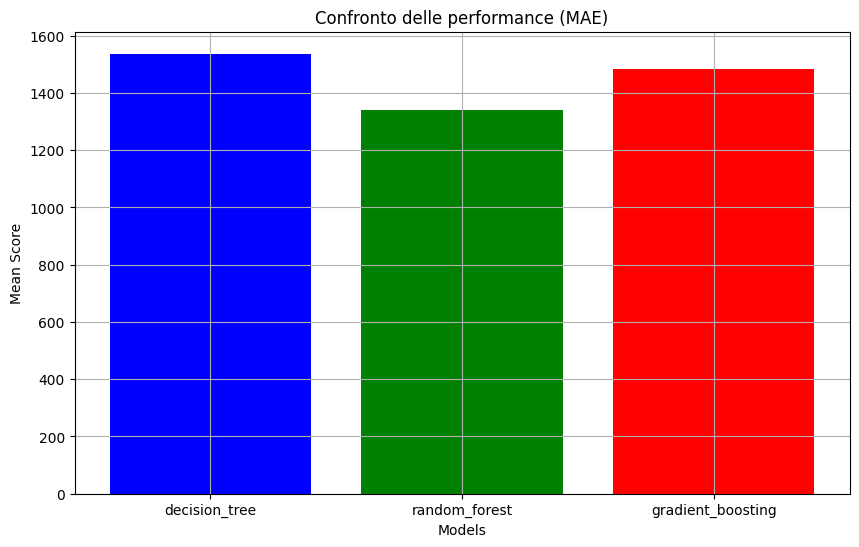

In [55]:
performance_comparison(results)

## Learning Curve

Saved Learning Curve (decision_tree, MAE).png
                                 Model  Train Score Variance  \
0  Learning Curve (decision_tree, MAE)            243.197595   

   Test Score Variance  Train Score Std dev  Test Score Std dev  
0          2110.742108            15.594794           45.942813  


C:\Users\Valerio\AppData\Local\Temp\ipykernel_10156\3511975926.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat([variance_df, variance_data], ignore_index=True)


Saved Learning Curve (random_forest, MAE).png
                                 Model  Train Score Variance  \
0  Learning Curve (decision_tree, MAE)            243.197595   
1  Learning Curve (random_forest, MAE)             65.646942   

   Test Score Variance  Train Score Std dev  Test Score Std dev  
0          2110.742108            15.594794           45.942813  
1          5442.226393             8.102280           73.771447  
Saved Learning Curve (gradient_boosting, MAE).png
                                     Model  Train Score Variance  \
0      Learning Curve (decision_tree, MAE)            243.197595   
1      Learning Curve (random_forest, MAE)             65.646942   
2  Learning Curve (gradient_boosting, MAE)            203.026837   

   Test Score Variance  Train Score Std dev  Test Score Std dev  
0          2110.742108            15.594794           45.942813  
1          5442.226393             8.102280           73.771447  
2          3521.923527            14.24874

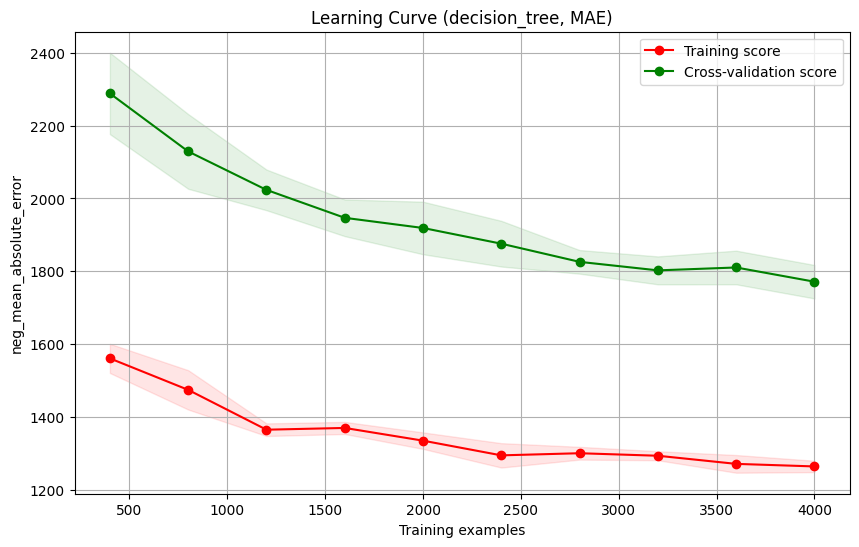

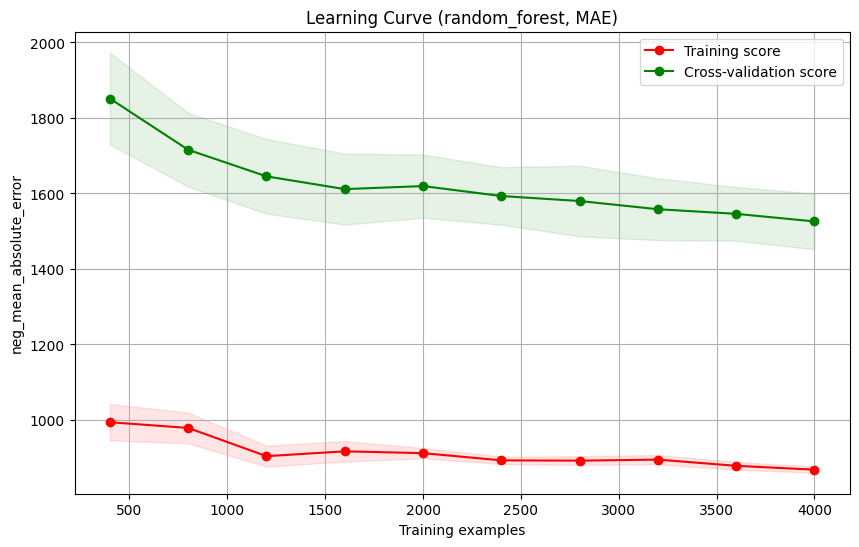

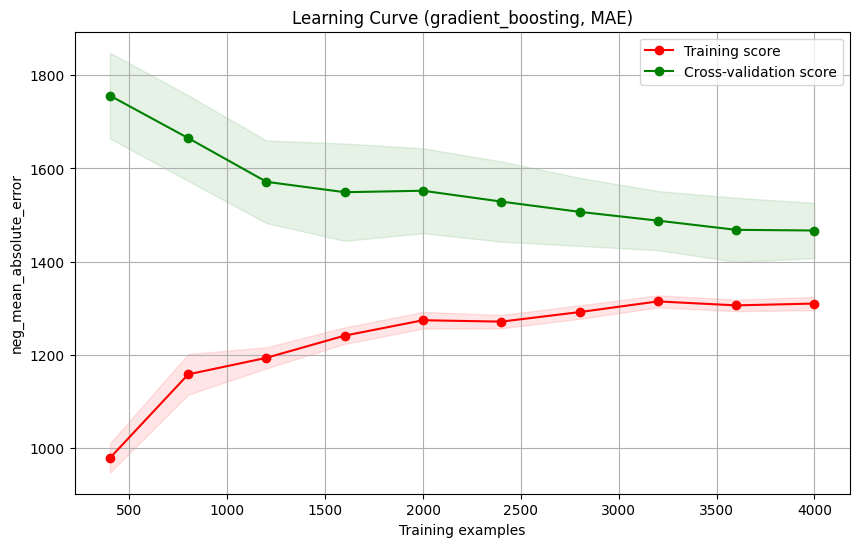

In [65]:
cv = RepeatedKFold(n_splits=5, n_repeats=1)
var_df = show_learning_curves(results, X, y, cv)
print(var_df.head())

# Regressione lineare, lasso e ridge

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge

results_linear = {s: {"linear_regression": {},
                      "lasso": {},
                      "ridge": {}} for s in scorings}

lr_param_grid = {
    'fit_intercept': [True, False],
}

lasso_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'max_iter': [1000, 10000],
    'selection': ['cyclic', 'random'],
}

ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'max_iter': [1000, 10000],
}

cv = RepeatedKFold(n_splits=5, n_repeats=2)

for scoring in scorings[:1]:
    lr = LinearRegression()
    print(f"Training linear regression with scoring metric {scoring}")
    results_linear[scoring]["linear_regression"] = search_hyperparameters(lr, lr_param_grid, X, y, cv, scoring, "Linear Regression")

    lasso = Lasso()
    print(f"Training lasso with scoring metric {scoring}")
    results_linear[scoring]["lasso"] = search_hyperparameters(lasso, lasso_param_grid, X, y, cv, scoring, "Lasso")

    ridge = Ridge()
    print(f"Training ridge with scoring metric {scoring}")
    results_linear[scoring]["ridge"] = search_hyperparameters(ridge, ridge_param_grid, X, y, cv, scoring, "Ridge")

print(results_linear)


Training linear regression with scoring metric neg_mean_absolute_error
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Error for Linear Regression:  2737.080165519073
Best params for Linear Regression:  {'fit_intercept': True}
Training lasso with scoring metric neg_mean_absolute_error
Fitting 10 folds for each of 48 candidates, totalling 480 fits


C:\Users\Valerio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.247e+10, tolerance: 1.239e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Valerio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.955e+10, tolerance: 1.225e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Valerio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

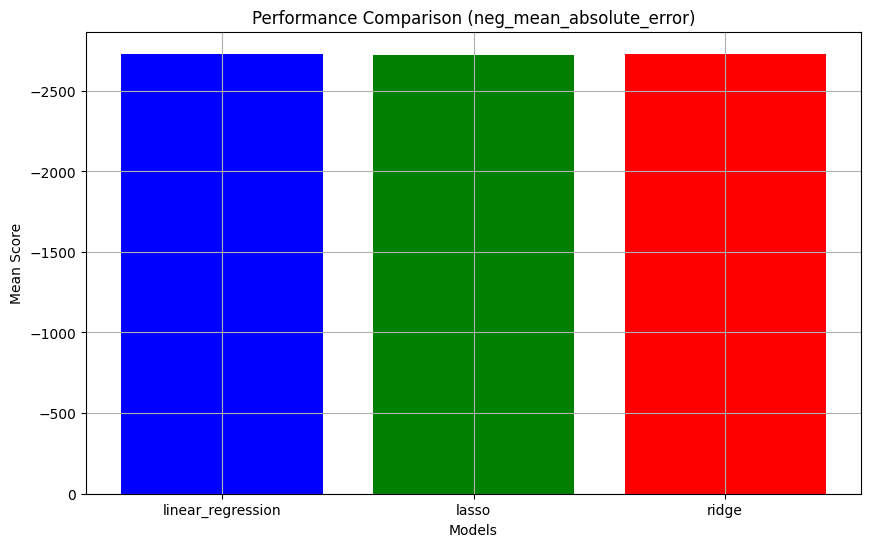

In [27]:
performance_comparison(results_linear)

Saved Learning Curve (linear_regression, neg_mean_absolute_error).png
                                               Model  Train Score Variance  \
0  Learning Curve (linear_regression, neg_mean_ab...             65.791851   

   Test Score Variance  Train Score Std dev  Test Score Std dev     Ratio  
0            624.18415             8.111218           24.983678  9.487256  


C:\Users\Valerio\AppData\Local\Temp\ipykernel_10156\82181739.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  variance_df = pd.concat([variance_df, variance_data], ignore_index=True)


Saved Learning Curve (lasso, neg_mean_absolute_error).png
                                               Model  Train Score Variance  \
0  Learning Curve (linear_regression, neg_mean_ab...             65.791851   
1    Learning Curve (lasso, neg_mean_absolute_error)             48.210273   

   Test Score Variance  Train Score Std dev  Test Score Std dev     Ratio  
0           624.184150             8.111218           24.983678  9.487256  
1           234.638557             6.943362           15.317916  4.866983  
Saved Learning Curve (ridge, neg_mean_absolute_error).png
                                               Model  Train Score Variance  \
0  Learning Curve (linear_regression, neg_mean_ab...             65.791851   
1    Learning Curve (lasso, neg_mean_absolute_error)             48.210273   
2    Learning Curve (ridge, neg_mean_absolute_error)             79.019177   

   Test Score Variance  Train Score Std dev  Test Score Std dev     Ratio  
0           624.184150          

,Model,Train Score Variance,Test Score Variance,Train Score Std dev,Test Score Std dev,Ratio
0,"Learning Curve (linear_regression, neg_mean_ab...",65.791851,624.184150,8.111218,24.983678,9.487256
1,"Learning Curve (lasso, neg_mean_absolute_error)",48.210273,234.638557,6.943362,15.317916,4.866983
2,"Learning Curve (ridge, neg_mean_absolute_error)",79.019177,421.541318,8.889273,20.531471,5.334671


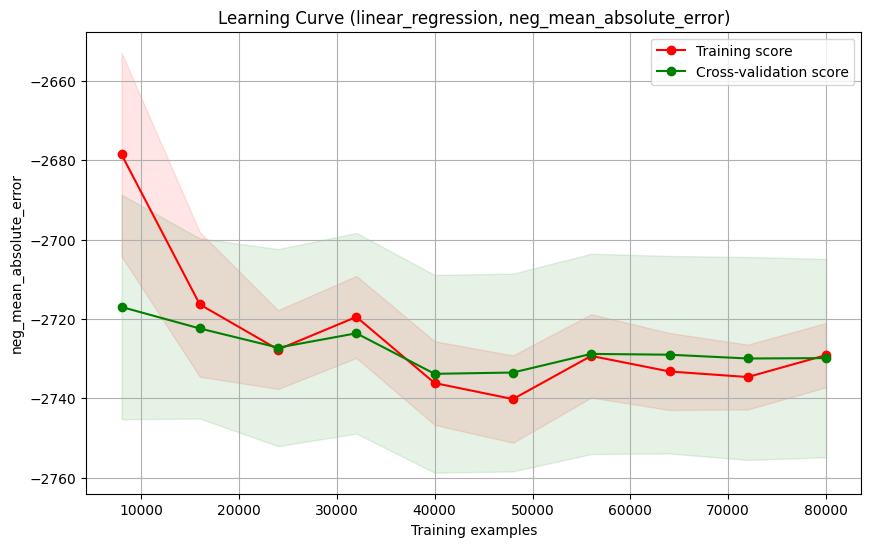

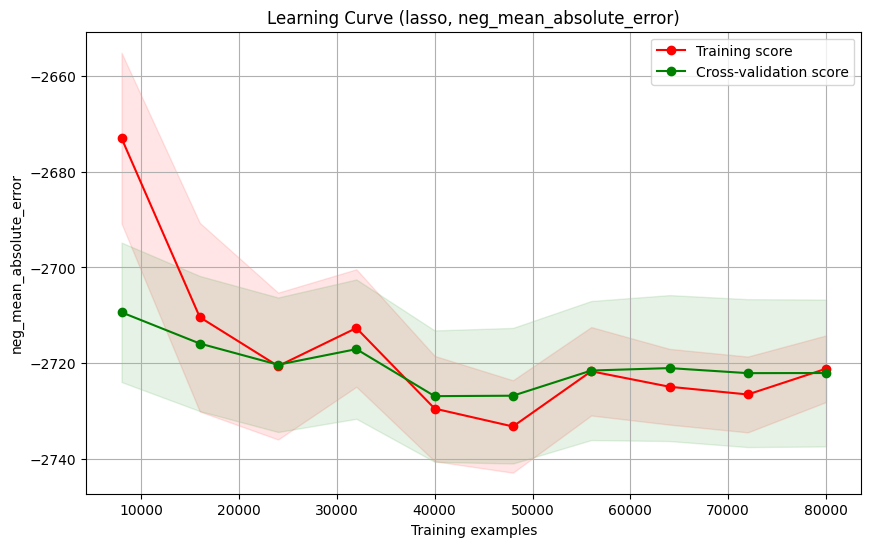

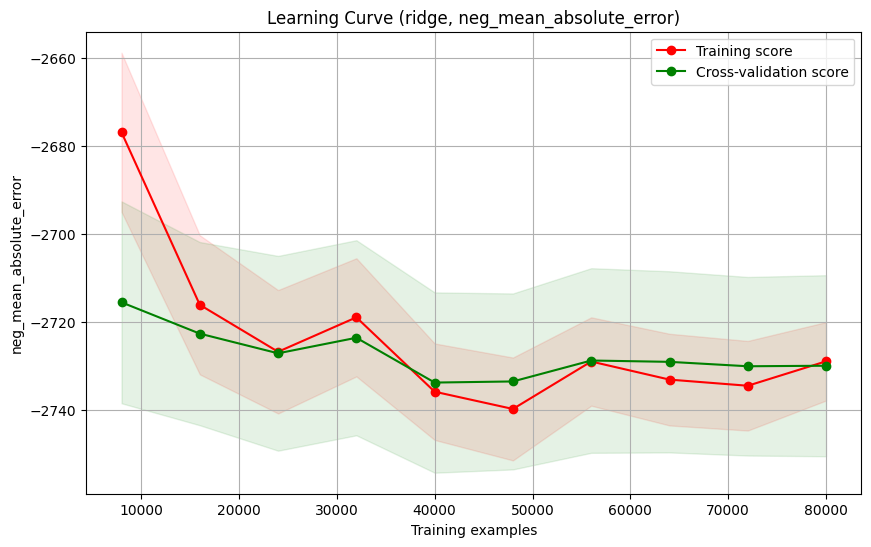

In [28]:
cv = RepeatedKFold(n_splits=5, n_repeats=2)
show_learning_curves(results_linear, X, y, cv)

# Da albero a prolog

In [11]:
from sklearn.tree import _tree


def extract_tree_structure(tree, feature_names):
    tree_ = tree.tree_
    feature_names = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_names[node]
            threshold = tree_.threshold[node]
            print(f"{indent}if ({name} <= {threshold:.2f}) {{")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}}} else {{")
            recurse(tree_.children_right[node], depth + 1)
            print(f"{indent}}}")
        else:
            print(f"{indent}return {tree_.value[node]}")

    recurse(0, 0)


# Extract tree structure
def tree_to_prolog(regressor, node_id=0, parent_id=None):
    base_code = """
% Prende in input una lista di features e salva man mano il prezzo piu alto
macchina_piu_costosa([Features|AltreMacchine], Macchina, Prezzo) :-
    predirre_prezzo(Features, PrezzoCorrente),
    macchina_piu_costosa(AltreMacchine, MaxMacchina, MaxPrezzo),
    (PrezzoCorrente > MaxPrezzo ->
     Macchina = Features, Prezzo = PrezzoCorrente
     ;
     Macchina = MaxMacchina, Prezzo = MaxPrezzo).

macchina_piu_costosa([], [], 0).


prezzo_conveniente(Features, PrezzoProposto) :-
    predirre_prezzo(Features, PrezzoPredetto),
    PrezzoProposto < PrezzoPredetto.


predirre_prezzo(Features, Prezzo) :-
    percorri_albero(0, Features, Prezzo).

% Passo base
percorri_albero(NodeID, _, Predizione) :-
    leaf(NodeID, Predizione).

% Passo ricorsivo
percorri_albero(NodeID, Features, Predizione) :-
    node(NodeID, FeatureIndex, Threshold, LeftChild, RightChild),
    nth0(FeatureIndex, Features, FeatureValue),
    (FeatureValue =< Threshold ->
        percorri_albero(LeftChild, Features, Predizione)
    ;
        percorri_albero(RightChild, Features, Predizione)
    ).

"""

    result = ""
    # Check if it's a leaf node
    if regressor.tree_.children_left[node_id] == -1:
        # Leaf node
        value = regressor.tree_.value[node_id][0, 0]  # Assuming single target value
        result += f"leaf({node_id}, {value}).\n"
    else:
        # Decision node
        feature = regressor.tree_.feature[node_id]
        threshold = regressor.tree_.threshold[node_id]
        left_child = regressor.tree_.children_left[node_id]
        right_child = regressor.tree_.children_right[node_id]
        result += f"node({node_id}, {feature}, {threshold}, {left_child}, {right_child}).\n"
        # Recursively add left and right children
        result += tree_to_prolog(regressor, left_child, node_id)
        result += tree_to_prolog(regressor, right_child, node_id)
    result = "\n".join(sorted(result.split("\n")))
    if parent_id is None:
        return base_code + result
    return result


dtree = list(results.values())[0]["decision_tree"]["model"]
pl = tree_to_prolog(dtree)
with open("decision_tree.pl", "w", encoding="utf-8") as f:
    f.write(pl)


In [13]:
from pyswip import Prolog

prolog = Prolog()
prolog.consult("decision_tree.pl")

features = list(X.iloc[0].values.astype(float))

print(f"Features: {features}")

prolog_pred = prolog.query(f"predirre_prezzo({features}, Prediction)")
print(f"Prolog DT prediction: {list(prolog_pred)}")

dtree_pred = dtree.predict([X.iloc[0].values])
print(f"Scikit-learn DT prediction: {dtree_pred}")


Features: [1998.0, 1.0, 136.0, 150000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Prolog prediction: [{'Prediction': 1600.0}]
Decision tree prediction: [1600.]


C:\Users\Valerio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## Stima del prezzo per una macchina

In [3]:
import pandas
from pyswip import Prolog

prolog = Prolog()
prolog.consult("conveniente.pl")

predirre_prezzo = prolog.query("predirre_prezzo([coupe,2011,false,190,125000,true,audi,true], Prezzo).")
print(list(predirre_prezzo))

convieniente = prolog.query("prezzo_conveniente([coupe,2011,false,190,125000,true,audi,true], 10000).")
print(bool(list(convieniente)))

macchina_piu_costosa = prolog.query(
    "macchina_piu_costosa([[coupe,2011,false,190,125000,true,audi,true],"
    "[coupe,2015,false,190,125000,true,audi,true]], Macchina, Prezzo)."
)
print(f"Macchina più costosa: {list(macchina_piu_costosa)}")


def macchina_piu_costosa_in_lista(lista_macchine):
    lista_macchine_str = str(lista_macchine).replace("True", "true").replace("False", "false").replace("'", "")
    macchina_piu_costosa = prolog.query(f"macchina_piu_costosa({lista_macchine_str}, Macchina, Prezzo).")
    return list(macchina_piu_costosa)


dataset_macchine = pandas.read_csv("preprocessed_data.csv")
dataset_macchine = dataset_macchine.drop(columns=["price"])
lista_macchine = dataset_macchine.values.tolist()
macchina_piu_costosa2 = macchina_piu_costosa_in_lista(lista_macchine)
print(f"Macchina più costosa di tutto il dataset: {macchina_piu_costosa2}")


[{'Prezzo': 16450.0}]
True
Macchina più costosa: [{'Macchina': ['coupe', 2015, 'false', 190, 125000, 'true', 'audi', 'true'], 'Prezzo': 17250.0}]
Macchina più costosa di tutto il dataset: [{'Macchina': ['sedan', 2015, 'true', 455, 5000, 'false', 'mercedes_benz', 'false'], 'Prezzo': 35050.0}]


# Apprendimento Bayesiano

In [2]:
from pgmpy.estimators import HillClimbSearch

# Utilizzo di HillClimbSearch per apprendere la struttura
hc = HillClimbSearch(discr_df)
best_model = hc.estimate()

print(best_model.edges())


  0%|          | 0/1000000 [00:00<?, ?it/s]

[('price', 'brand'), ('price', 'powerHP'), ('vehicleType', 'powerHP'), ('vehicleType', 'brand'), ('vehicleType', 'price'), ('vehicleType', 'gearboxAutomatic'), ('vehicleType', 'notRepairedDamage'), ('yearOfRegistration', 'price'), ('yearOfRegistration', 'brand'), ('yearOfRegistration', 'powerHP'), ('yearOfRegistration', 'vehicleType'), ('yearOfRegistration', 'notRepairedDamage'), ('yearOfRegistration', 'gearboxAutomatic'), ('yearOfRegistration', 'fuelTypeDiesel'), ('gearboxAutomatic', 'brand'), ('gearboxAutomatic', 'price'), ('gearboxAutomatic', 'powerHP'), ('powerHP', 'brand'), ('kilometer', 'yearOfRegistration'), ('kilometer', 'brand'), ('kilometer', 'price'), ('kilometer', 'powerHP'), ('kilometer', 'fuelTypeDiesel'), ('kilometer', 'vehicleType'), ('fuelTypeDiesel', 'brand'), ('fuelTypeDiesel', 'vehicleType'), ('fuelTypeDiesel', 'powerHP'), ('fuelTypeDiesel', 'price'), ('fuelTypeDiesel', 'gearboxAutomatic'), ('notRepairedDamage', 'brand'), ('notRepairedDamage', 'price'), ('notRepaire

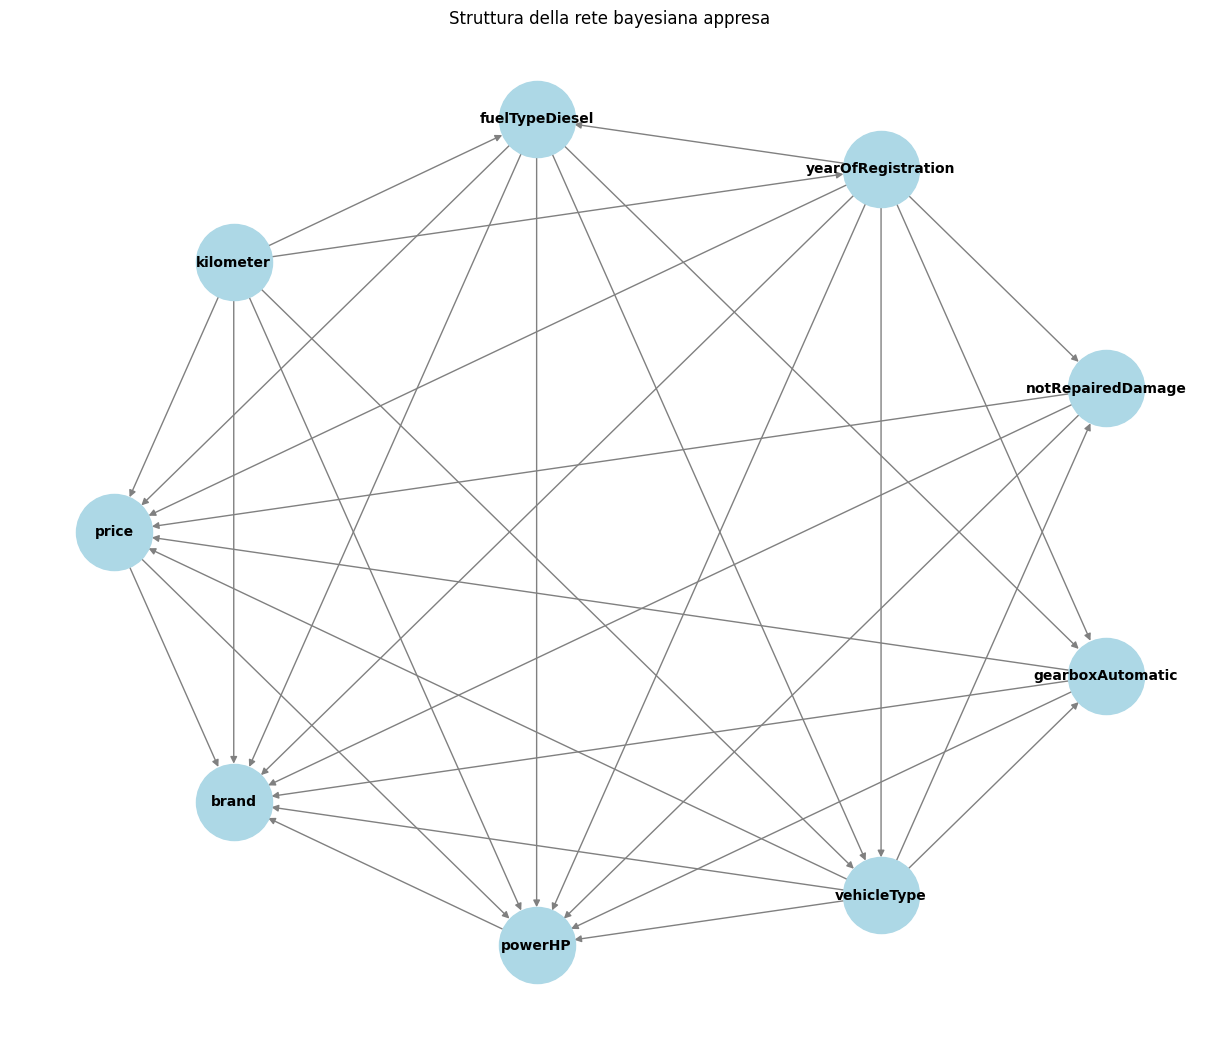

In [3]:
# Mostra grafico della struttura appresa
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from(best_model.edges())

# Draw the graph with a shell layout
plt.figure(figsize=(12, 10))
pos = nx.shell_layout(G)  # use shell layout for better separation of nodes
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue",
        font_size=10, font_weight="bold", arrows=True, edge_color="gray")
plt.title("Struttura della rete bayesiana appresa")
plt.show()

# A -> B significa che A influenza direttamente B


In [21]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

model = BayesianNetwork(best_model.edges())

# Apprendere le CPDs dai dati
model.fit(discr_df, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=len(discr_df) / 100)

assert model.check_model()


In [22]:
# mostra cpd delle variabili

variabili = ["price", "yearOfRegistration"]
for cpd in model.get_cpds():
    if cpd.variable in variabili:
        print(f"CPD per variabile {cpd.variable}")
        print(cpd)

CPD per variabile price
+--------------------+-----+---------------------------+
| fuelTypeDiesel     | ... | fuelTypeDiesel(True)      |
+--------------------+-----+---------------------------+
| gearboxAutomatic   | ... | gearboxAutomatic(True)    |
+--------------------+-----+---------------------------+
| kilometer          | ... | kilometer(150000)         |
+--------------------+-----+---------------------------+
| notRepairedDamage  | ... | notRepairedDamage(True)   |
+--------------------+-----+---------------------------+
| vehicleType        | ... | vehicleType(stationwagon) |
+--------------------+-----+---------------------------+
| yearOfRegistration | ... | yearOfRegistration(9)     |
+--------------------+-----+---------------------------+
| price(0)           | ... | 0.005070993914807302      |
+--------------------+-----+---------------------------+
| price(1)           | ... | 0.005070993914807302      |
+--------------------+-----+---------------------------+
| price

In [46]:
from pgmpy.inference import VariableElimination

inference = VariableElimination(model)


def infer_query(variables, evidence):
    predicted_vars = inference.map_query(variables, evidence)
    print(f"Evidence: {evidence}")
    print(f'Predicted variables: {predicted_vars}')
    return predicted_vars


evidence_example = dict(X_discr.iloc[4])
infer_query(variables=["price"], evidence=evidence_example)

# Esempio di inferenza con 
evidence_example = {'price': 7,
                    'yearOfRegistration': 7,
                    'gearboxAutomatic': True,
                    'powerHP': 4,
                    'fuelTypeDiesel': False,
                    'notRepairedDamage': True
                    }

infer_query(["vehicleType", "brand"], evidence_example)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Evidence: {'vehicleType': 'cabrio', 'yearOfRegistration': 7, 'gearboxAutomatic': False, 'powerHP': 4, 'kilometer': 100000, 'fuelTypeDiesel': False, 'brand': 'opel', 'notRepairedDamage': False}
Predicted variables: {'price': 6}


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Evidence: {'price': 7, 'yearOfRegistration': 7, 'gearboxAutomatic': True, 'powerHP': 4, 'fuelTypeDiesel': False, 'notRepairedDamage': True}
Predicted variables: {'brand': 'audi', 'vehicleType': 'sedan'}


{'brand': 'audi', 'vehicleType': 'sedan'}

In [10]:
# discr_df.isnull().sum()
n = 23
print(dict(X_discr.iloc[n]))
print(y_discr.iloc[n])

{'vehicleType': 'coupe', 'yearOfRegistration': 8, 'gearboxAutomatic': False, 'powerHP': 9, 'kilometer': 100000, 'fuelTypeDiesel': True, 'brand': 'audi', 'notRepairedDamage': False}
9
